In [22]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
import time

In [14]:
def Image_processor(path, display):
    
    #remove color intensity bar
    
    image = cv2.imread(path)
    original = image.copy()
    image = image[:,:720,:]
    
    #compute contours
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 1)
    edged = cv2.Canny(blurred, 100, 150)
    (contour_image, cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    #display
    if(display):
        orig = image.copy()

        cv2.imshow("orig",original)
        cv2.drawContours(orig, cnts, -1, (0, 255, 0), 2)
        cv2.imshow("orig-with-cont",orig)
        cv2.imshow("conturs", contour_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    contour_image = np.array(contour_image)
    return contour_image

In [15]:
im = Image_processor('D:/Data_projects/PhiPSII/June05-02.bmp',True)

In [16]:
def Image_separate(image):
    
    image_dry = image[:,0:309]
    image_watered = image[:,410:720]
    
    return image_dry,image_watered

In [17]:
def Image_fit(epsilon, path):
        
    
    contour_image = Image_processor(path, False)
    image_dry,image_watered = Image_separate(contour_image)
    
    dry_distribution = []
    watered_distribution = []
    
    dry_x_indeces, dry_y_indeces = np.where(image_dry>0)
    watered_x_indeces, watered_y_indeces = np.where(image_watered > 0)
    
    dry = pd.DataFrame({'x':dry_x_indeces,'y':dry_y_indeces})
    watered = pd.DataFrame({'x':watered_x_indeces,'y':watered_y_indeces})
    
    for i in range(0,watered_x_indeces.shape[0]):
        
        x_low = max(0,watered_x_indeces[i]-epsilon)
        x_high = min(image_watered.shape[0],watered_x_indeces[i]+epsilon)
        y_low = max(0,watered_y_indeces[i]-epsilon)
        y_high = min(image_watered.shape[1],watered_y_indeces[i]+epsilon)
        
        watered_fit_data = watered[(x_low < watered['x']) & (watered['x'] < x_high) & (y_low < watered['y']) & (watered['y'] < y_high)]
        
        if(watered_fit_data.shape[0]>4):
            x = watered_fit_data.x.values
            y = watered_fit_data.y.values
            x = x.reshape(watered_fit_data.shape[0], 1)
            y = y.reshape(watered_fit_data.shape[0], 1)

            regr = linear_model.LinearRegression()
            regr.fit(x,y)
            watered_distribution.append(regr.score(x,y))
        
    for i in range(0,dry_x_indeces.shape[0]):

        x_low = max(0,dry_x_indeces[i]-epsilon)
        x_high = min(image_dry.shape[0],dry_x_indeces[i]+epsilon)
        y_low = max(0,dry_y_indeces[i]-epsilon)
        y_high = min(image_dry.shape[1],dry_y_indeces[i]+epsilon)
        
        dry_fit_data = dry[(x_low <= dry['x']) & (dry['x'] <= x_high) & (y_low <= dry['y']) & (dry['y'] <= y_high)]
          
        if(dry_fit_data.shape[0]>7):
          
            x = dry_fit_data.x.values
            y = dry_fit_data.y.values
            x = x.reshape(dry_fit_data.shape[0], 1)
            y = y.reshape(dry_fit_data.shape[0], 1)

            regr = linear_model.LinearRegression()
            regr.fit(x,y)
            dry_distribution.append(regr.score(x,y))
        
    return watered_distribution,dry_distribution

In [18]:
start_time = time.time()
dist_water, dist_dry = Image_fit(3,'D:/Data_projects/PhiPSII/June05-02.bmp')
print("--- %s seconds ---" % (time.time() - start_time))

--- 61.445576667785645 seconds ---


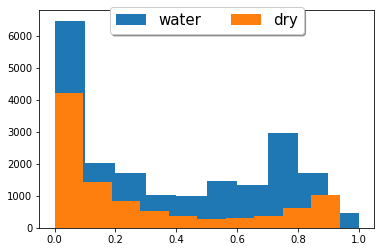

In [19]:
plt.hist(dist_water, label = 'water')
plt.hist(dist_dry, label = 'dry')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True, prop={'size': 15})

In [2]:
2**32

4294967296

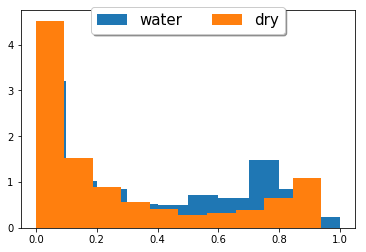

In [20]:
plt.hist(dist_water, label = 'water',density=1)
plt.hist(dist_dry, label = 'dry', density=1)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True, prop={'size': 15})

In [19]:
from scipy.stats import ranksums as wilcx 
from scipy.stats import ttest_ind as ttest

In [18]:
wilcx(dist_water,dist_dry)

RanksumsResult(statistic=21.821803494314157, pvalue=1.4406448480017005e-105)

In [22]:
ttest(dist_water,dist_dry,equal_var=True)

Ttest_indResult(statistic=24.487765710225254, pvalue=2.2130334104123008e-131)

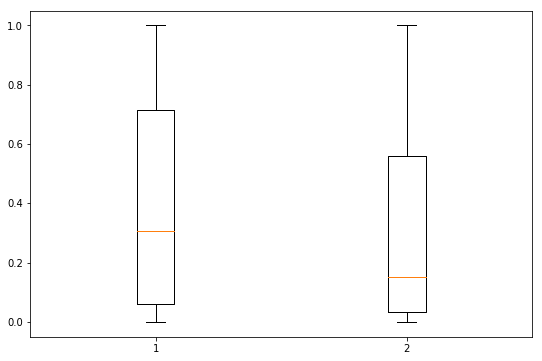

In [45]:
xx = [dist_water,dist_dry]
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Water', 'Dry'])
bp = ax.boxplot(xx,0,'gD')